## Using Random Forest to predict the next day regime

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np

ml_df = yf.download('^GSPC', start="1978-01-01", interval="1d")

for i in [1, 2, 3, 5, 7, 14, 21]:
    ml_df[f'Close_{i}_Value'] = ml_df['Adj Close'].pct_change(i)
    ml_df[f'Volume_{i}_Value'] = ml_df['Volume'].pct_change(i)
ml_df.dropna(inplace=True)
for i in [3, 7, 14, 21]:
    ml_df[f'Volt_{i}_Value'] = np.log(1 + ml_df['Close_1_Value']).rolling(i).std()
ml_df.dropna(inplace=True)  

/Users/alden/quantfin/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [20]:
# vix = yf.download('^VIX', start="1990-01-01", interval="1d")
# vix.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
# vix.index = pd.to_datetime(vix.index)
# vix.rename(columns={'Close':'VIX'}, inplace=True)

In [21]:
sp500_regimes = pd.read_csv('../data/sp500_regimes.csv')
sp500_regimes.set_index('Date', inplace=True)
sp500_regimes.index = pd.to_datetime(sp500_regimes.index)
ml_df.index = pd.to_datetime(ml_df.index)
data = pd.merge(ml_df.drop(columns=['High','Low','Open','Close','Adj Close']), sp500_regimes, on='Date',how='inner')
# data = pd.merge(data, vix, on='Date', how='inner')

In [22]:
# Assuming df is your DataFrame
# data['day_in_regime'] = data.groupby((data['color'] != data['color'].shift()).cumsum()).cumcount() + 1
# data.drop(columns=['Open','High','Close','Low'], inplace=True)

In [23]:
data['color'] = data['color'].shift(-1)
data.dropna(inplace=True)

In [24]:
X = data.drop(columns=['color'])
y = data['color']

In [25]:
from sklearn.model_selection import train_test_split
from collections import Counter

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
Counter(y_train)

Counter({'blue': 6280, 'pink': 1070, 'red': 719, 'green': 495})

The data is skewed, this means classes are unqeually represented. This may affect model's performance. Hence, performing under/oversampling is recommended

## Performing oversampling of the smaller classes

In [26]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import NeighbourhoodCleaningRule, TomekLinks, EditedNearestNeighbours
from sklearn.preprocessing import LabelEncoder

# Assuming X is your dataset and y is the target variable
oversampler = SMOTE()  # Choose your oversampler: RandomOverSampler, SMOTE, or ADASYN
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)


In [27]:
Counter(y_resampled)

Counter({'red': 6280, 'blue': 6280, 'pink': 6280, 'green': 6280})

We can see now that the classes are more equally represented

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=191, random_state=42)
rf.fit(X_resampled, y_resampled)

RandomForestClassifier(n_estimators=191, random_state=42)

In [12]:
y_pred = rf.predict(X_test)
y_prob_pred = rf.predict_proba(X_test)

## Accuracy of model

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix

acc_score = accuracy_score(y_test, y_pred)
# false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
# roc_auc = auc(false_positive_rate, true_positive_rate)
acc_score

0.9808500700607193

## Confusion Matrix

Confusion Matrix:
[[1551    0    9    0]
 [   4  133    0    9]
 [   9    1  248    2]
 [   0    6    1  168]]


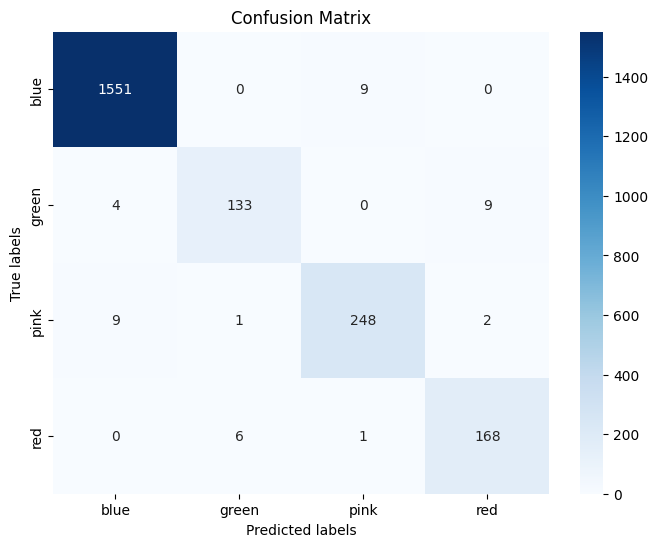

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = np.unique(y_test)

# Compute the confusion matrix with labels
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Print the confusion matrix with labels
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix as a heatmap with labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

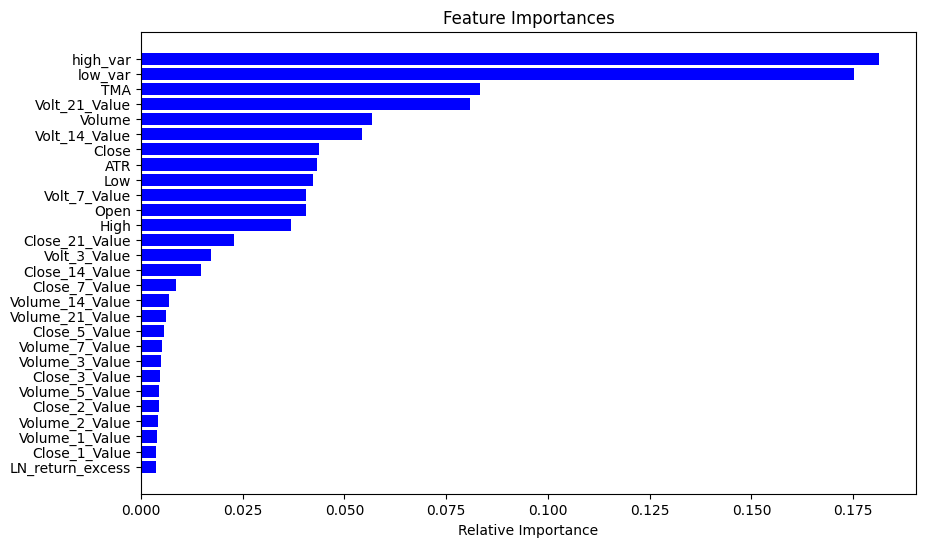

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = rf.feature_importances_

# Get the indices sorted by importance
indices = np.argsort(importances)

# Get the feature names
features = X_train.columns

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [16]:
from sklearn.metrics import f1_score


f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' if you have a multi-class problem

print(f'F1 Score: {f1}')

F1 Score: 0.9807863232928702


In [17]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

def rf_cv(n_estimators):
    model = RandomForestClassifier(n_estimators=int(n_estimators),
                                   random_state=42)
    return cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='accuracy').mean()

param_bounds = {'n_estimators': (10, 200)}

optimizer = BayesianOptimization(f=rf_cv, pbounds=param_bounds, random_state=42)

# Perform the optimization
optimizer.maximize(init_points=10, n_iter=15)

|   iter    |  target   | n_esti... |
-------------------------------------
| 1         | 0.9898    | 81.16     |
| 2         | 0.9905    | 190.6     |
| 3         | 0.9901    | 149.1     |
| 4         | 0.9902    | 123.7     |
| 5         | 0.9891    | 39.64     |
| 6         | 0.9891    | 39.64     |
| 7         | 0.9879    | 21.04     |
| 8         | 0.9904    | 174.6     |
| 9         | 0.9901    | 124.2     |
| 10        | 0.9902    | 144.5     |
| 11        | 0.9903    | 105.1     |
| 12        | 0.9904    | 200.0     |
| 13        | 0.9891    | 61.85     |
| 14        | 0.9902    | 113.8     |
| 15        | 0.99      | 93.86     |
| 16        | 0.9902    | 164.1     |
| 17        | 0.9903    | 182.9     |
| 18        | 0.9903    | 195.2     |
| 19        | 0.9903    | 169.9     |
| 20        | 0.9903    | 137.2     |
| 21        | 0.9901    | 157.0     |
| 22        | 0.9905    | 188.0     |
| 23        | 0.9903    | 118.6     |
| 24        | 0.9905    | 189.0     |
| 25        

In [18]:
print(optimizer.max)

{'target': 0.9905295060033152, 'params': {'n_estimators': 188.01027708059345}}


In [32]:
from sklearn.metrics import roc_auc_score

# Predict probabilities for the positive class
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC with OvR strategy
auc_roc_ovr = roc_auc_score(y_test, rf.predict_proba(X_test), multi_class='ovr', average='macro')
print('AUC-ROC OvR:', auc_roc_ovr)

AUC-ROC OvR: 0.9973549418365192
